In [1]:
!unzip data.zip

Archive:  data.zip
  inflating: lenta_sample.csv        
  inflating: __MACOSX/._lenta_sample.csv  


In [3]:
import tensorflow as tf

In [4]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data = pd.read_csv('lenta_sample.csv')

Предобработка нам тут особо не важна.

In [6]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

В предыдущей домашке не хватало фмеры. Ее нет в керасе, но можно взять вот такую функцию (взятую со стаковерфлоу)

In [7]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Предобработка точно такая же

In [8]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [9]:
len(vocab)

670782

In [10]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [11]:
len(filtered_vocab)

55293

In [12]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [13]:
id2word = {i:word for word, i in word2id.items()}

In [14]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [15]:
MAX_LEN = max(len(x) for x in X)

Можно посчитать среднюю или медианную длину, если максимальная кажется слишком большой.

In [16]:
MEAN_LEN = np.median([len(x) for x in X])

In [17]:
MAX_LEN, MEAN_LEN

(3578, 170.0)

In [18]:
MAX_LEN = int(MEAN_LEN + 30)

In [19]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [20]:
X.shape

(147852, 200)

In [21]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [22]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [23]:
len(label2id)

19

В этот раз добавим стратификацию, т.к. в данных у нас дисбаланс классов.

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=42)

Рекурретную сеть можно применить в прямом и обратном порядке и объединить состояния в одно (половина вектора будет про инфу до, половина про инфу после). Это назвается Bidirectional и делается в tf очень просто. 

In [25]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

# 1 слой на 2 прогона
# lstm = tf.keras.layers.LSTM(128, return_sequences=False)
# lstm_forward = lstm(embeddings)
# lstm_backward = lstm(embeddings[::-1])

# 2 слоя
lstm_forward =  tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)
lstm_backward =  tf.keras.layers.LSTM(128, return_sequences=False, go_backwards=True)(embeddings)

hidden = tf.keras.layers.concatenate([lstm_forward, lstm_backward])

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(hidden)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [26]:
model.summary()
# обратите внимание на размер output в biderectional
# он равен units * 2

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 30)      1658820     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 128)          81408       embedding[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          81408       embedding[0][0]                  
______________________________________________________________________________________________

In [27]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10)

Epoch 1/10
11/71 [===>..........................] - ETA: 2:01 - loss: 2.6068 - f1: 0.0000e+00 - rec@prec: 0.0000e+00

KeyboardInterrupt: 

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


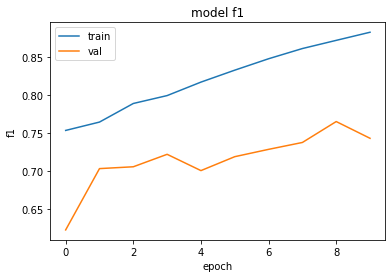

In [59]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()